In [249]:
from dataset import MysqlIO
import pandas as pd
# import pandas_profiling as pp
# from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import add_prefix_to_colnames, onehot, str_to_datetime, summary_df, day_to_int

%matplotlib inline

# Load Dataset

In [250]:
# db = MysqlIO(host='relational.fit.cvut.cz', 
#             database='financial', 
#             user='guest', 
#             password='relational')

# print(db.execute('SHOW TABLES'))

# loan_df = db.execute_to_df('SELECT * FROM loan')
# order_df = db.execute_to_df('SELECT * FROM `order`')
# trans_df = db.execute_to_df('''
#     SELECT * FROM trans WHERE account_id IN 
#     (SELECT account_id FROM loan)
#    ''')
# disp_df = db.execute_to_df('SELECT * FROM disp')
# account_df = db.execute_to_df('SELECT * FROM account')
# client_df = db.execute_to_df('SELECT * FROM client')
# card_df = db.execute_to_df('SELECT * FROM card')
# district_df = db.execute_to_df('SELECT * FROM district')

In [251]:
loan_df = pd.read_csv('data/loan.csv')
order_df = pd.read_csv('data/order.csv')
trans_df = pd.read_csv('data/trans.csv')
disp_df = pd.read_csv('data/disp.csv')
account_df = pd.read_csv('data/account.csv')
client_df = pd.read_csv('data/client.csv')
card_df = pd.read_csv('data/card.csv')
district_df = pd.read_csv('data/district.csv')

In [252]:
summary_df(loan_df, "loan")
summary_df(order_df, "order")
summary_df(trans_df, "trans")
summary_df(disp_df, "disp")
summary_df(account_df, "account")
summary_df(client_df, "client")
summary_df(card_df, "card")
summary_df(district_df, "district")

loan
(682, 7)


,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C


missing value


loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

order
(6471, 6)


,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,NaN


missing value


order_id         0
account_id       0
bank_to          0
account_to       0
amount           0
k_symbol      1379
dtype: int64

trans
(191556, 10)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,276,2,1993-02-26,PRIJEM,VKLAD,1100,1100,NaN,NaN,NaN
1,279,2,1993-03-12,PRIJEM,PREVOD Z UCTU,20236,21336,NaN,ST,66487163.0
2,280,2,1993-04-12,PRIJEM,PREVOD Z UCTU,20236,45286,NaN,ST,66487163.0
3,281,2,1993-05-12,PRIJEM,PREVOD Z UCTU,20236,54631,NaN,ST,66487163.0
4,282,2,1993-06-12,PRIJEM,PREVOD Z UCTU,30354,67530,NaN,ST,66487163.0


missing value


trans_id           0
account_id         0
date               0
type               0
operation      31338
amount             0
balance            0
k_symbol       92447
bank          141043
account       128931
dtype: int64

disp
(5369, 4)


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


missing value


disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

account
(4500, 4)


,account_id,district_id,frequency,date
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26
2,3,5,POPLATEK MESICNE,1997-07-07
3,4,12,POPLATEK MESICNE,1996-02-21
4,5,15,POPLATEK MESICNE,1997-05-30


missing value


account_id     0
district_id    0
frequency      0
date           0
dtype: int64

client
(5369, 4)


,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1
2,3,F,1940-10-09,1
3,4,M,1956-12-01,5
4,5,F,1960-07-03,5


missing value


client_id      0
gender         0
birth_date     0
district_id    0
dtype: int64

card
(892, 4)


,card_id,disp_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24


missing value


card_id    0
disp_id    0
type       0
issued     0
dtype: int64

district
(77, 16)


,district_id,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.9,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.6,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616.0,3040


missing value


district_id    0
A2             0
A3             0
A4             0
A5             0
A6             0
A7             0
A8             0
A9             0
A10            0
A11            0
A12            1
A13            0
A14            0
A15            1
A16            0
dtype: int64

# Facts you need to know about Dataset

![title](img/Data_description.png)

Data Description
* relation account (4500 records) - each record describes static characteristics of an account,
* relation client (5369 records) - each record describes characteristics of a client,
* relation disposition (5369 records) - each record relates together a client with an account i.e. this relation describes the rights of clients to operate accounts,
* relation permanent order (6471 records) - each record describes characteristics of a payment order,
* relation transaction (1056320 records) - each record describes one transaction on an account,
* relation loan (682 records) - each record describes a loan granted for a given account,
* relation credit card (892 records) - each record describes a credit card issued to an account,
* relation demographic data (77 records) - each record describes demographic characteristics of a district.

Deeper (you don't need to know)
* 1 client can have multiple accounts.
Also, 1 account can have multiple clients (owner, desponent).
* sanction if negative balance. sometimes amount is 0.

# Data manipulation

## loan table

In [253]:
loan_df_ = add_prefix_to_colnames(loan_df, prefix='loan_')
loan_df_['loan_payments'] = loan_df_['loan_payments'].astype('int64')
loan_df_['loan_date'] = str_to_datetime(loan_df_['loan_date'])
print(loan_df_.shape)
loan_df_.head()

(682, 7)


,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status
0,4959,2,1994-01-05,80952,24,3373,A
1,4961,19,1996-04-29,30276,12,2523,B
2,4962,25,1997-12-08,30276,12,2523,A
3,4967,37,1998-10-14,318480,60,5308,D
4,4968,38,1998-04-19,110736,48,2307,C


In [254]:
# loan_df_.to_csv('table_csv/loan.csv', index=False)

## account table
* Edit 'frequency' field to English.
* Create feature 'day_before_loan'.

In [255]:
account_df.loc[account_df['frequency']=="POPLATEK MESICNE", 'frequency'] = 'monthly'
account_df.loc[account_df['frequency']=="POPLATEK TYDNE", 'frequency'] = 'weekly'
account_df.loc[account_df['frequency']=="POPLATEK PO OBRATU", 'frequency'] = 'after_transaction'
account_df.head()

,account_id,district_id,frequency,date
0,1,18,monthly,1995-03-24
1,2,1,monthly,1993-02-26
2,3,5,monthly,1997-07-07
3,4,12,monthly,1996-02-21
4,5,15,monthly,1997-05-30


In [256]:
# account_df.to_csv('table_csv/account.csv', index=False)

In [257]:
account_df_ = add_prefix_to_colnames(account_df, prefix='acc_')
account_df_['acc_date'] = str_to_datetime(account_df_['acc_date'])
print(account_df_.shape)
account_df_.head()

(4500, 4)


,account_id,acc_district_id,acc_frequency,acc_date
0,1,18,monthly,1995-03-24
1,2,1,monthly,1993-02-26
2,3,5,monthly,1997-07-07
3,4,12,monthly,1996-02-21
4,5,15,monthly,1997-05-30


In [258]:
df = pd.merge(loan_df_, account_df_, how='left', on=['account_id'])
df['day_before_loan'] = df['loan_date'] - df['acc_date']
df['day_before_loan'] = day_to_int(df['day_before_loan'])
df = df.drop(['acc_date'], axis=1)
print(df.shape)
df.head()

(682, 10)


,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,acc_district_id,acc_frequency,day_before_loan
0,4959,2,1994-01-05,80952,24,3373,A,1,monthly,313
1,4961,19,1996-04-29,30276,12,2523,B,21,monthly,388
2,4962,25,1997-12-08,30276,12,2523,A,68,monthly,498
3,4967,37,1998-10-14,318480,60,5308,D,20,monthly,422
4,4968,38,1998-04-19,110736,48,2307,C,19,weekly,254


## order manipulation

each record describes characteristics of a payment order (monthly).

We can extract all of the features in this table from the transaction table.

So, we decided not to use this table.

In [259]:
order_df.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,NaN


order_df there are "spacing". so, we add NaN.

In [260]:
# order_df['k_symbol'].value_counts()

In [261]:
# order_df = order_df.replace("", np.nan)
# order_df['k_symbol'].value_counts()

In [262]:
# order_df.loc[order_df['k_symbol']=="POJISTNE", 'k_symbol'] = 'insurrance'
# order_df.loc[order_df['k_symbol']=="SIPO", 'k_symbol'] = 'household'
# order_df.loc[order_df['k_symbol']=="LEASING", 'k_symbol'] = 'leasing'
# order_df.loc[order_df['k_symbol']=="UVER", 'k_symbol'] = 'loan'

# # print(order_df.shape)
# order_df.head()

In [263]:
# add_prefix_to_colnames(order_df, prefix='order_').to_csv('table_csv/order.csv', index=False)

drop k_symbol nan because we don't know what k_symbol it is.

In [264]:
# order_df = order_df[order_df['k_symbol'].notna()]
# order_df.head()

k_symbol onehot encoding

this tells us, each account have had monthly payment in each k_symbol.

In [265]:
# order_df_ = onehot(order_df, col_name='k_symbol', prefix='monthly_payment_for')
# order_df_.head()

multiple each k_symbol with its amount. because this tells us each mont the account need to pay how much. not just have had pay for what.

In [266]:
# order_df_['monthly_payment_for_household'] = order_df_['monthly_payment_for_household'] * order_df_['amount'] 
# order_df_['monthly_payment_for_insurrance'] = order_df_['monthly_payment_for_insurrance'] * order_df_['amount'] 
# order_df_['monthly_payment_for_leasing'] = order_df_['monthly_payment_for_leasing'] * order_df_['amount'] 
# order_df_['monthly_payment_for_loan'] = order_df_['monthly_payment_for_loan'] * order_df_['amount']
# order_df_.head()

Drop bank_to, account_to, k_symbol

In [267]:
# order_df_ = order_df_.drop(['order_id', 'bank_to', 'account_to', 'amount'], axis=1)
# order_df_.head()

In [268]:
# order_df_ = add_prefix_to_colnames(order_df_, prefix='order_')
# order_df_.head()

Order -> useless เพราะ k_symbol ของ transaction ละเอียดกว่า

In [269]:
# df = pd.merge(df, order_df_, how='left', on=['account_id'])
# df = pd.merge(df, order_ksymbol, how='left', on=['account_id'])
df.head()

,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,acc_district_id,acc_frequency,day_before_loan
0,4959,2,1994-01-05,80952,24,3373,A,1,monthly,313
1,4961,19,1996-04-29,30276,12,2523,B,21,monthly,388
2,4962,25,1997-12-08,30276,12,2523,A,68,monthly,498
3,4967,37,1998-10-14,318480,60,5308,D,20,monthly,422
4,4968,38,1998-04-19,110736,48,2307,C,19,weekly,254


## Transaction

* Replace None (null values), spacing with NaN
* Rename feature 'type', 'operation', 'k_symbol' to English.
* Money in, Money out -> separate amount to amount_in, amount_out
* Separate data to Before loan and After loan (we can use only Before loan data)

In [270]:
summary_df(trans_df)


(191556, 10)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,276,2,1993-02-26,PRIJEM,VKLAD,1100,1100,NaN,NaN,NaN
1,279,2,1993-03-12,PRIJEM,PREVOD Z UCTU,20236,21336,NaN,ST,66487163.0
2,280,2,1993-04-12,PRIJEM,PREVOD Z UCTU,20236,45286,NaN,ST,66487163.0
3,281,2,1993-05-12,PRIJEM,PREVOD Z UCTU,20236,54631,NaN,ST,66487163.0
4,282,2,1993-06-12,PRIJEM,PREVOD Z UCTU,30354,67530,NaN,ST,66487163.0


missing value


trans_id           0
account_id         0
date               0
type               0
operation      31338
amount             0
balance            0
k_symbol       92447
bank          141043
account       128931
dtype: int64

replace None (null values), spacing with NaN

In [271]:
# check values not in list (show spacing)
trans_df.loc[~trans_df['k_symbol'].isin(["POJISTNE", "SLUZBY", "UROK", "SANKC. UROK", "SIPO", "DUCHOD", "UVER", np.nan]) , :].head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
888,6294,25,1996-10-06,VYDAJ,PREVOD NA UCET,1110,79600,,AB,79838293.0
889,6295,25,1996-11-06,VYDAJ,PREVOD NA UCET,1110,65325,,AB,79838293.0
890,6296,25,1996-12-06,VYDAJ,PREVOD NA UCET,1110,68099,,AB,79838293.0
891,6297,25,1997-01-06,VYDAJ,PREVOD NA UCET,1110,58744,,AB,79838293.0
892,6298,25,1997-02-06,VYDAJ,PREVOD NA UCET,1110,81076,,AB,79838293.0


In [272]:
# fill spacing with nan
trans_df = trans_df.replace(' ', np.nan)
# fill None with nan
trans_df = trans_df.fillna(value=np.nan)
# check
trans_df.loc[~trans_df['k_symbol'].isin(["POJISTNE", "SLUZBY", "UROK", "SANKC. UROK", "SIPO", "DUCHOD", "UVER", np.nan]) , :]

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account


type have class "PRIJEM", "VYDAJ". Also "VYBER" (not show in https://web.archive.org/web/20180506035658/http://lisp.vse.cz/pkdd99/Challenge/berka.htm)

include "VYBER" to "VYDAJ" as withdrawal.

In [273]:
trans_df = trans_df.sort_values(by=['account_id', 'date'])
trans_df = trans_df.copy()
# type
trans_df.loc[trans_df['type']=="PRIJEM", 'type'] = 'credit'
trans_df.loc[trans_df['type']=="VYDAJ", 'type'] = 'withdrawal'
trans_df.loc[trans_df['type']=="VYBER", 'type'] = 'withdrawal'

# operation
trans_df.loc[trans_df['operation']=="VYBER KARTOU", 'operation'] = 'credit_card_withdrawal'
trans_df.loc[trans_df['operation']=="VKLAD", 'operation'] = 'credit_in_cash'
trans_df.loc[trans_df['operation']=="PREVOD Z UCTU", 'operation'] = 'collection_from_anotherbank'
trans_df.loc[trans_df['operation']=="VYBER", 'operation'] = 'withdrawal_in_cash'
trans_df.loc[trans_df['operation']=="PREVOD NA UCET", 'operation'] = 'remittance_to_anotherbank'

# k_symbol
trans_df.loc[trans_df['k_symbol']=="POJISTNE", 'k_symbol'] = 'insurrance'
trans_df.loc[trans_df['k_symbol']=="SLUZBY", 'k_symbol'] = 'payment_for_statement'
trans_df.loc[trans_df['k_symbol']=="UROK", 'k_symbol'] = 'interest_credited'
trans_df.loc[trans_df['k_symbol']=="SANKC. UROK", 'k_symbol'] = 'sanction_interest_neg_bal'
trans_df.loc[trans_df['k_symbol']=="SIPO", 'k_symbol'] = 'household'
trans_df.loc[trans_df['k_symbol']=="DUCHOD", 'k_symbol'] = 'old-age_pension'
trans_df.loc[trans_df['k_symbol']=="UVER", 'k_symbol'] = 'loan'

# date
trans_df['date'] = str_to_datetime(trans_df['date'])

trans_df

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,276,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,NaN,NaN
1,279,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,ST,66487163.0
338,697,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,NaN,NaN
408,3530483,2,1993-03-31,credit,NaN,14,25050,interest_credited,NaN,NaN
2,280,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,ST,66487163.0
...,...,...,...,...,...,...,...,...,...,...
191318,3424092,11362,1998-12-08,withdrawal,remittance_to_anotherbank,56,51420,NaN,MN,78507822.0
191284,3424044,11362,1998-12-10,withdrawal,remittance_to_anotherbank,4780,46640,household,YZ,70641225.0
191420,3424236,11362,1998-12-12,withdrawal,remittance_to_anotherbank,5392,41248,loan,MN,61540514.0
191425,3424248,11362,1998-12-19,withdrawal,withdrawal_in_cash,2880,38368,NaN,NaN,NaN


In [274]:
# add_prefix_to_colnames(trans_df, prefix='trans_').to_csv('table_csv/transaction.csv', index=False)

### money in, money out

In [275]:
trans_df_in = trans_df.copy()
trans_df_in.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,276,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,NaN,NaN
1,279,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,ST,66487163.0
338,697,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,NaN,NaN
408,3530483,2,1993-03-31,credit,NaN,14,25050,interest_credited,NaN,NaN
2,280,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,ST,66487163.0


In [276]:
def money_in_out(df, focus_colname, cond_colname='type', in_colname='credit', out_colname='withdrawal'):
    money_in = df[df[cond_colname] == in_colname][focus_colname]
    money_out = df[df[cond_colname] == out_colname][focus_colname]

    return [money_in, money_out]

trans_df_in.loc[trans_df_in['type'] == 'credit', 'amount_in'] = money_in_out(trans_df_in, focus_colname='amount')[0] # trans_df_before_loan[trans_df_before_loan['type'] == 'credit']['amount']
trans_df_in.loc[trans_df_in['type'] == 'withdrawal', 'amount_out'] = money_in_out(trans_df_in, focus_colname='amount')[1]
trans_df_in.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,amount_in,amount_out
0,276,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,NaN,NaN,1100.0,NaN
1,279,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,ST,66487163.0,20236.0,NaN
338,697,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,NaN,NaN,3700.0,NaN
408,3530483,2,1993-03-31,credit,NaN,14,25050,interest_credited,NaN,NaN,14.0,NaN
2,280,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,ST,66487163.0,20236.0,NaN


In [277]:
# replace amount in out nan with 0
trans_df_in.loc[:, ['amount_in', 'amount_out']] = trans_df_in.loc[:, ['amount_in', 'amount_out']].replace(np.nan, 0)
trans_df_in

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,amount_in,amount_out
0,276,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,NaN,NaN,1100.0,0.0
1,279,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,ST,66487163.0,20236.0,0.0
338,697,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,NaN,NaN,3700.0,0.0
408,3530483,2,1993-03-31,credit,NaN,14,25050,interest_credited,NaN,NaN,14.0,0.0
2,280,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,ST,66487163.0,20236.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
191318,3424092,11362,1998-12-08,withdrawal,remittance_to_anotherbank,56,51420,NaN,MN,78507822.0,0.0,56.0
191284,3424044,11362,1998-12-10,withdrawal,remittance_to_anotherbank,4780,46640,household,YZ,70641225.0,0.0,4780.0
191420,3424236,11362,1998-12-12,withdrawal,remittance_to_anotherbank,5392,41248,loan,MN,61540514.0,0.0,5392.0
191425,3424248,11362,1998-12-19,withdrawal,withdrawal_in_cash,2880,38368,NaN,NaN,NaN,0.0,2880.0


### Focus only transaction before loan

In [278]:
trans_df_in.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,amount_in,amount_out
0,276,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,NaN,NaN,1100.0,0.0
1,279,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,ST,66487163.0,20236.0,0.0
338,697,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,NaN,NaN,3700.0,0.0
408,3530483,2,1993-03-31,credit,NaN,14,25050,interest_credited,NaN,NaN,14.0,0.0
2,280,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,ST,66487163.0,20236.0,0.0


In [279]:
# drop unnecessary features
trans_df_in = trans_df_in.drop(['trans_id', 'bank', 'account'], axis=1)

In [280]:
trans_df_before_loan = pd.merge(trans_df_in, loan_df_[['account_id', 'loan_date']], how='left', on='account_id')
trans_df_before_loan['day_after_loan'] = day_to_int(trans_df_before_loan['loan_date'] - trans_df_before_loan['date'])

# after loan
trans_df_after_loan = trans_df_before_loan[trans_df_before_loan['day_after_loan']<=0]
# before loan
trans_df_before_loan = trans_df_before_loan[trans_df_before_loan['day_after_loan']>0]

# trans_df_before_loan = trans_df_before_loan.drop(['day_after_loan', 'loan_date'], axis=1)
print(trans_df_before_loan.shape)
trans_df_before_loan.head()

(54694, 11)


,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,1100.0,0.0,1994-01-05,313
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,20236.0,0.0,1994-01-05,299
2,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,3700.0,0.0,1994-01-05,283
3,2,1993-03-31,credit,NaN,14,25050,interest_credited,14.0,0.0,1994-01-05,280
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,20236.0,0.0,1994-01-05,268


In [281]:
# trans_df_after_loan = trans_df_after_loan.drop(['day_after_loan', 'loan_date'], axis=1)
print(trans_df_after_loan.shape)
trans_df_after_loan.head()

(136862, 11)


,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
54,2,1994-01-05,withdrawal,remittance_to_anotherbank,7266,20575,household,0.0,7266.0,1994-01-05,0
55,2,1994-01-12,credit,collection_from_anotherbank,20236,40811,NaN,20236.0,0.0,1994-01-05,-7
56,2,1994-01-12,withdrawal,remittance_to_anotherbank,3373,35338,loan,0.0,3373.0,1994-01-05,-7
57,2,1994-01-12,withdrawal,withdrawal_in_cash,2100,38711,NaN,0.0,2100.0,1994-01-05,-7
58,2,1994-01-18,withdrawal,withdrawal_in_cash,2400,32938,NaN,0.0,2400.0,1994-01-05,-13


In [282]:
# print(trans_df_before_loan['type'].value_counts(), '\n')
# print(trans_df_before_loan['operation'].value_counts(), '\n')
# print(trans_df_before_loan['k_symbol'].value_counts(), '\n')

In [283]:
# print(trans_df_after_loan['type'].value_counts(), '\n')
# print(trans_df_after_loan['operation'].value_counts(), '\n')
# print(trans_df_after_loan['k_symbol'].value_counts(), '\n')

In [284]:
trans_df_out = trans_df_before_loan.copy()

In [285]:
# trans_df_before_loan.to_csv('data/trans_before_loan.csv', index=False)

In [286]:
# trans_df_after_loan.to_csv('data/trans_after_loan.csv', index=False)

### Explore Operation & k_symbol

In [287]:
trans_df_in = trans_df_out.copy()

In [288]:
trans_df_in['operation'].fillna('Others', inplace=True)
trans_df_in['k_symbol'].fillna('Others', inplace=True)
trans_df_in.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,Others,1100.0,0.0,1994-01-05,313
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,Others,20236.0,0.0,1994-01-05,299
2,2,1993-03-28,credit,credit_in_cash,3700,25036,Others,3700.0,0.0,1994-01-05,283
3,2,1993-03-31,credit,Others,14,25050,interest_credited,14.0,0.0,1994-01-05,280
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,Others,20236.0,0.0,1994-01-05,268


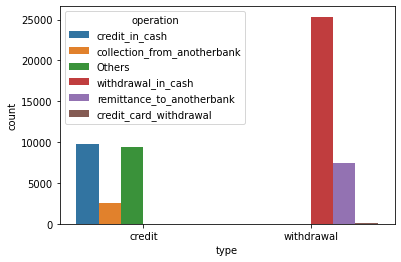

In [289]:
sns.countplot(data=trans_df_in, x='type', hue='operation')
plt.show()

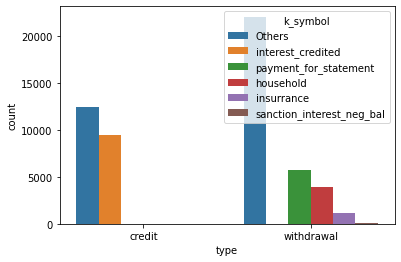

In [290]:
sns.countplot(data=trans_df_in, x='type', hue='k_symbol')
plt.show()

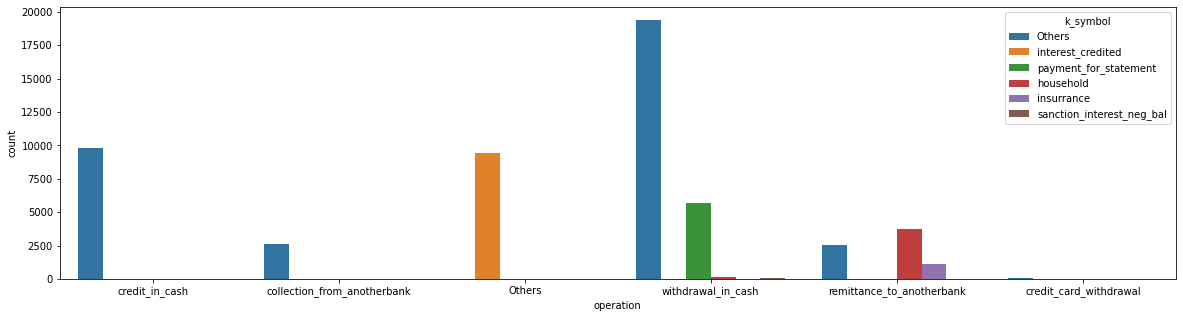

In [291]:
plt.figure(figsize=(20, 5))
sns.countplot(data=trans_df_in, x='operation', hue='k_symbol')
plt.show()

The operation categorical simply tells us how money enters and leaves.
As a result, it is unimportant. So we don't mind the operation.

In [292]:
trans_df_out = trans_df_in.copy()

### Monthly payment (permanent order)

focus only monthly transaction. \
We can see this using k_symbol.
1. one-hot encoding to k_symbol

2. Create features for total monthly payments 
(count sanction, money amount in each k_symbol) 

*This tells us how much each account has paid us and whether or not they have been sanctioned.*

3. Create features for current monthly payments by determining the previous month's payment for each account. (amount of money paid in each k symbol last month)

*This tells us what you have to pay each month and how much you have to pay now.*

4. merge Total monthly payment features and Current monthly payment.

In [293]:
trans_df_in = trans_df_out[trans_df_out['k_symbol']!='Others']
print(trans_df_in.shape)
trans_df_in.head()

(20272, 11)


,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
3,2,1993-03-31,credit,Others,14,25050,interest_credited,14.0,0.0,1994-01-05,280
6,2,1993-04-30,credit,Others,110,34395,interest_credited,110.0,0.0,1994-01-05,250
9,2,1993-05-31,credit,Others,145,37176,interest_credited,145.0,0.0,1994-01-05,219
12,2,1993-06-30,credit,Others,160,45290,interest_credited,160.0,0.0,1994-01-05,189
17,2,1993-07-31,withdrawal,withdrawal_in_cash,15,39069,payment_for_statement,0.0,15.0,1994-01-05,158


In [294]:
trans_df_ = trans_df_in.copy()

In [295]:
# onehot
trans_df_ = onehot(trans_df_, col_name='k_symbol', prefix='out',drop=False)
trans_df_ = trans_df_.rename(columns={'out_interest_credited':'in_interest_credited'})
trans_df_.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,out_household,out_insurrance,in_interest_credited,out_payment_for_statement,out_sanction_interest_neg_bal
3,2,1993-03-31,credit,Others,14,25050,interest_credited,14.0,0.0,1994-01-05,280,0,0,1,0,0
6,2,1993-04-30,credit,Others,110,34395,interest_credited,110.0,0.0,1994-01-05,250,0,0,1,0,0
9,2,1993-05-31,credit,Others,145,37176,interest_credited,145.0,0.0,1994-01-05,219,0,0,1,0,0
12,2,1993-06-30,credit,Others,160,45290,interest_credited,160.0,0.0,1994-01-05,189,0,0,1,0,0
17,2,1993-07-31,withdrawal,withdrawal_in_cash,15,39069,payment_for_statement,0.0,15.0,1994-01-05,158,0,0,0,1,0


In [296]:
out_trans = ['out_household', 'out_insurrance', 'out_payment_for_statement', 'out_sanction_interest_neg_bal']
# count sanction if neg balance. 
trans_df_['count_out_sanction_interest_neg_bal'] = trans_df_['out_sanction_interest_neg_bal']

trans_df_.loc[:, out_trans] = trans_df_[out_trans].multiply(trans_df_["amount_out"], axis=0)


trans_df_.loc[:, 'in_interest_credited'] = trans_df_['in_interest_credited'].multiply(trans_df_["amount_in"], axis=0)
trans_df_.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,out_household,out_insurrance,in_interest_credited,out_payment_for_statement,out_sanction_interest_neg_bal,count_out_sanction_interest_neg_bal
3,2,1993-03-31,credit,Others,14,25050,interest_credited,14.0,0.0,1994-01-05,280,0.0,0.0,14.0,0.0,0.0,0
6,2,1993-04-30,credit,Others,110,34395,interest_credited,110.0,0.0,1994-01-05,250,0.0,0.0,110.0,0.0,0.0,0
9,2,1993-05-31,credit,Others,145,37176,interest_credited,145.0,0.0,1994-01-05,219,0.0,0.0,145.0,0.0,0.0,0
12,2,1993-06-30,credit,Others,160,45290,interest_credited,160.0,0.0,1994-01-05,189,0.0,0.0,160.0,0.0,0.0,0
17,2,1993-07-31,withdrawal,withdrawal_in_cash,15,39069,payment_for_statement,0.0,15.0,1994-01-05,158,0.0,0.0,0.0,15.0,0.0,0


In [297]:
trans_monthly_payment = trans_df_.loc[:, ['account_id', 'amount', 'amount_in', 'amount_out', 'out_household', 'out_insurrance', 'in_interest_credited', 'out_payment_for_statement', 'out_sanction_interest_neg_bal', 'count_out_sanction_interest_neg_bal']].copy()
trans_monthly_payment = trans_monthly_payment.groupby(by='account_id').sum().reset_index()

trans_monthly_payment['count_monthly_trans'] = trans_df_.groupby(by='account_id', as_index=False).count()['amount']

trans_monthly_payment = add_prefix_to_colnames(trans_monthly_payment, prefix='sum_monthly_payment_')
trans_monthly_payment = trans_monthly_payment.rename(columns={'sum_monthly_payment_count_monthly_trans':'count_monthly_payment_trans', 'sum_monthly_payment_count_out_sanction_interest_neg_bal':'count_out_sanction_interest_neg_bal'})
trans_monthly_payment

,account_id,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,sum_monthly_payment_out_household,sum_monthly_payment_out_insurrance,sum_monthly_payment_in_interest_credited,sum_monthly_payment_out_payment_for_statement,sum_monthly_payment_out_sanction_interest_neg_bal,count_out_sanction_interest_neg_bal,count_monthly_payment_trans
0,2,37711,1291.0,36420.0,36330.0,0.0,1291.0,90.0,0.0,0,21
1,19,130355,2835.0,127520.0,127400.0,0.0,2835.0,120.0,0.0,0,40
2,25,102031,4087.0,97944.0,95438.0,2296.0,4087.0,210.0,0.0,0,57
3,37,31436,2303.0,29133.0,27804.0,1164.0,2303.0,165.0,0.0,1,50
4,38,29750,1114.0,28636.0,27604.0,912.0,1114.0,120.0,0.0,0,20
...,...,...,...,...,...,...,...,...,...,...,...
674,11327,24415,2167.0,22248.0,22158.0,0.0,2167.0,90.0,0.0,0,22
675,11328,3636,3411.0,225.0,0.0,0.0,3411.0,225.0,0.0,0,34
676,11349,11643,757.0,10886.0,10886.0,0.0,757.0,0.0,0.0,0,5
677,11359,80673,3597.0,77076.0,76806.0,0.0,3597.0,270.0,0.0,0,57


In [298]:
trans_df_['last_month'] = trans_df_['loan_date'] - pd.Timedelta(days=31)

In [299]:
current_monthly_payment = trans_df_[day_to_int(trans_df_['date']-trans_df_['last_month']) >= 0][['date', 'account_id', 'amount_out', 'out_household', 'out_insurrance', 'out_payment_for_statement', 'in_interest_credited']]
current_monthly_payment = current_monthly_payment.groupby(by='account_id', as_index=False).sum()
current_monthly_payment = add_prefix_to_colnames(current_monthly_payment, prefix='current_monthly_payment_')
current_monthly_payment

,account_id,current_monthly_payment_amount_out,current_monthly_payment_out_household,current_monthly_payment_out_insurrance,current_monthly_payment_out_payment_for_statement,current_monthly_payment_in_interest_credited
0,2,7281.0,7266.0,0.0,15.0,138.0
1,19,18215.0,18200.0,0.0,15.0,168.0
2,25,6996.0,6817.0,164.0,15.0,372.0
3,37,2429.0,2317.0,97.0,15.0,94.0
4,38,7159.0,6901.0,228.0,30.0,117.0
...,...,...,...,...,...,...
674,11327,3708.0,3693.0,0.0,15.0,272.0
675,11328,15.0,0.0,0.0,15.0,189.0
676,11349,10886.0,10886.0,0.0,0.0,263.0
677,11359,4533.0,4518.0,0.0,15.0,110.0


In [300]:
trans_monthly_payment_summary = pd.merge(trans_monthly_payment, current_monthly_payment, how='left', on=['account_id'])
trans_monthly_payment_summary

,account_id,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,sum_monthly_payment_out_household,sum_monthly_payment_out_insurrance,sum_monthly_payment_in_interest_credited,sum_monthly_payment_out_payment_for_statement,sum_monthly_payment_out_sanction_interest_neg_bal,count_out_sanction_interest_neg_bal,count_monthly_payment_trans,current_monthly_payment_amount_out,current_monthly_payment_out_household,current_monthly_payment_out_insurrance,current_monthly_payment_out_payment_for_statement,current_monthly_payment_in_interest_credited
0,2,37711,1291.0,36420.0,36330.0,0.0,1291.0,90.0,0.0,0,21,7281.0,7266.0,0.0,15.0,138.0
1,19,130355,2835.0,127520.0,127400.0,0.0,2835.0,120.0,0.0,0,40,18215.0,18200.0,0.0,15.0,168.0
2,25,102031,4087.0,97944.0,95438.0,2296.0,4087.0,210.0,0.0,0,57,6996.0,6817.0,164.0,15.0,372.0
3,37,31436,2303.0,29133.0,27804.0,1164.0,2303.0,165.0,0.0,1,50,2429.0,2317.0,97.0,15.0,94.0
4,38,29750,1114.0,28636.0,27604.0,912.0,1114.0,120.0,0.0,0,20,7159.0,6901.0,228.0,30.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,11327,24415,2167.0,22248.0,22158.0,0.0,2167.0,90.0,0.0,0,22,3708.0,3693.0,0.0,15.0,272.0
675,11328,3636,3411.0,225.0,0.0,0.0,3411.0,225.0,0.0,0,34,15.0,0.0,0.0,15.0,189.0
676,11349,11643,757.0,10886.0,10886.0,0.0,757.0,0.0,0.0,0,5,10886.0,10886.0,0.0,0.0,263.0
677,11359,80673,3597.0,77076.0,76806.0,0.0,3597.0,270.0,0.0,0,57,4533.0,4518.0,0.0,15.0,110.0


In [301]:
# replace NaN with zero.
df = pd.merge(df, trans_monthly_payment_summary, how='left', on=['account_id'])
df = df.replace(np.nan, 0)
df.isna().any().any() # check that there is nan or not

False

In [302]:
# df.to_csv('incloud_monthly_trans.csv', index=False)

divide transaction amount sum, count with day before loan

In [303]:
# t = df.copy()

In [304]:
# t_list = ['sum_monthly_payment_amount', 'sum_monthly_payment_amount_in', 'sum_monthly_payment_amount_out', 'sum_monthly_payment_out_household','sum_monthly_payment_out_insurrance','sum_monthly_payment_in_interest_credited','sum_monthly_payment_out_payment_for_statement','sum_monthly_payment_out_sanction_interest_neg_bal','count_out_sanction_interest_neg_bal', 'count_monthly_payment_trans','current_monthly_payment_amount_out','current_monthly_payment_out_household','current_monthly_payment_out_insurrance','current_monthly_payment_out_payment_for_statement','current_monthly_payment_in_interest_credited']
# t.loc[:, t_list] = t[t_list].div(t['day_before_loan'], axis=0)

In [305]:
# t.to_csv('incloud_monthly_trans_normbyday.csv', index=False)

### Other transactions

Create features 
* sum other amount
* sum_other_amount_in, sum_other_amount_out
* count other trans

การใช้จ่ายอื่น ๆ (ที่ไม่ใช่จ่ายรายเดือนใน k_symbol)

In [306]:
trans_df_in = trans_df_out[trans_df_out['k_symbol']=='Others']
print(trans_df_in.shape)
trans_df_in.head()

(34422, 11)


,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,Others,1100.0,0.0,1994-01-05,313
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,Others,20236.0,0.0,1994-01-05,299
2,2,1993-03-28,credit,credit_in_cash,3700,25036,Others,3700.0,0.0,1994-01-05,283
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,Others,20236.0,0.0,1994-01-05,268
5,2,1993-04-27,withdrawal,withdrawal_in_cash,11000,34286,Others,0.0,11000.0,1994-01-05,253


In [307]:
trans_orthers = trans_df_in.loc[:, ['account_id', 'amount', 'amount_in', 'amount_out']].groupby(by='account_id').sum().reset_index()
trans_orthers.loc[:, ['count_other_trans']] = trans_df_in.groupby(by='account_id', as_index=False).count()['amount']

trans_orthers = add_prefix_to_colnames(trans_orthers, prefix='sum_other_')
trans_orthers = trans_orthers.rename(columns={'sum_other_count_other_trans':'count_other_trans'})
trans_orthers

,account_id,sum_other_amount,sum_other_amount_in,sum_other_amount_out,count_other_trans
0,2,391823,227396.0,164427.0,33
1,19,338153,239345.0,98808.0,40
2,25,1884662,1005069.0,879593.0,107
3,37,846920,445057.0,401863.0,66
4,38,229641,147290.0,82351.0,35
...,...,...,...,...,...
677,11327,406396,244296.0,162100.0,32
678,11328,859072,443592.0,415480.0,72
679,11349,428034,231434.0,196600.0,13
680,11359,1199517,649336.0,550181.0,90


In [308]:
df = pd.merge(df, trans_orthers, how='left', on=['account_id'])
df.head()

,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,acc_district_id,acc_frequency,day_before_loan,...,count_monthly_payment_trans,current_monthly_payment_amount_out,current_monthly_payment_out_household,current_monthly_payment_out_insurrance,current_monthly_payment_out_payment_for_statement,current_monthly_payment_in_interest_credited,sum_other_amount,sum_other_amount_in,sum_other_amount_out,count_other_trans
0,4959,2,1994-01-05,80952,24,3373,A,1,monthly,313,...,21.0,7281.0,7266.0,0.0,15.0,138.0,391823,227396.0,164427.0,33
1,4961,19,1996-04-29,30276,12,2523,B,21,monthly,388,...,40.0,18215.0,18200.0,0.0,15.0,168.0,338153,239345.0,98808.0,40
2,4962,25,1997-12-08,30276,12,2523,A,68,monthly,498,...,57.0,6996.0,6817.0,164.0,15.0,372.0,1884662,1005069.0,879593.0,107
3,4967,37,1998-10-14,318480,60,5308,D,20,monthly,422,...,50.0,2429.0,2317.0,97.0,15.0,94.0,846920,445057.0,401863.0,66
4,4968,38,1998-04-19,110736,48,2307,C,19,weekly,254,...,20.0,7159.0,6901.0,228.0,30.0,117.0,229641,147290.0,82351.0,35


### balance latest

In [309]:
trans_df_before_loan.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,1100.0,0.0,1994-01-05,313
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,20236.0,0.0,1994-01-05,299
2,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,3700.0,0.0,1994-01-05,283
3,2,1993-03-31,credit,NaN,14,25050,interest_credited,14.0,0.0,1994-01-05,280
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,20236.0,0.0,1994-01-05,268


In [310]:
trans_df_before_loan = trans_df_before_loan.sort_values(by=['account_id', 'date'])
df['balance_latest'] = trans_df_before_loan.groupby('account_id').tail(1)['balance'].reset_index(drop=True)
df.head()

,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,acc_district_id,acc_frequency,day_before_loan,...,current_monthly_payment_amount_out,current_monthly_payment_out_household,current_monthly_payment_out_insurrance,current_monthly_payment_out_payment_for_statement,current_monthly_payment_in_interest_credited,sum_other_amount,sum_other_amount_in,sum_other_amount_out,count_other_trans,balance_latest
0,4959,2,1994-01-05,80952,24,3373,A,1,monthly,313,...,7281.0,7266.0,0.0,15.0,138.0,391823,227396.0,164427.0,33,27855
1,4961,19,1996-04-29,30276,12,2523,B,21,monthly,388,...,18215.0,18200.0,0.0,15.0,168.0,338153,239345.0,98808.0,40,15854
2,4962,25,1997-12-08,30276,12,2523,A,68,monthly,498,...,6996.0,6817.0,164.0,15.0,372.0,1884662,1005069.0,879593.0,107,31622
3,4967,37,1998-10-14,318480,60,5308,D,20,monthly,422,...,2429.0,2317.0,97.0,15.0,94.0,846920,445057.0,401863.0,66,16368
4,4968,38,1998-04-19,110736,48,2307,C,19,weekly,254,...,7159.0,6901.0,228.0,30.0,117.0,229641,147290.0,82351.0,35,37417


# Disp & Client & Card

In [311]:
summary_df(disp_df)
summary_df(client_df)
summary_df(card_df)


(5369, 4)


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


missing value


disp_id       0
client_id     0
account_id    0
type          0
dtype: int64


(5369, 4)


,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1
2,3,F,1940-10-09,1
3,4,M,1956-12-01,5
4,5,F,1960-07-03,5


missing value


client_id      0
gender         0
birth_date     0
district_id    0
dtype: int64


(892, 4)


,card_id,disp_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24


missing value


card_id    0
disp_id    0
type       0
issued     0
dtype: int64

In [312]:
dcc_df = pd.merge(disp_df, client_df, how='left', on='client_id')
dcc_df = pd.merge(dcc_df, card_df, how='left', on='disp_id')

dcc_df = dcc_df.rename(columns={'type_x': 'client_type', 'type_y':'card_type', 'issued':'card_issued'})
dcc_df.head()

,disp_id,client_id,account_id,client_type,gender,birth_date,district_id,card_id,card_type,card_issued
0,1,1,1,OWNER,F,1970-12-13,18,NaN,NaN,NaN
1,2,2,2,OWNER,M,1945-02-04,1,NaN,NaN,NaN
2,3,3,2,DISPONENT,F,1940-10-09,1,NaN,NaN,NaN
3,4,4,3,OWNER,M,1956-12-01,5,NaN,NaN,NaN
4,5,5,3,DISPONENT,F,1960-07-03,5,NaN,NaN,NaN


birth_date -> age

In [313]:
dcc_df['birth_date'] = pd.to_datetime(dcc_df['birth_date'], format='%Y-%m-%d')
today = pd.to_datetime("1999-01-01", format='%Y-%m-%d')
dcc_df['age'] = [today.year - d.year for d in dcc_df['birth_date']]
dcc_df = dcc_df.drop(['disp_id', 'birth_date', 'district_id', 'card_id'], axis=1)
dcc_df

,client_id,account_id,client_type,gender,card_type,card_issued,age
0,1,1,OWNER,F,NaN,NaN,29
1,2,2,OWNER,M,NaN,NaN,54
2,3,2,DISPONENT,F,NaN,NaN,59
3,4,3,OWNER,M,NaN,NaN,43
4,5,3,DISPONENT,F,NaN,NaN,39
...,...,...,...,...,...,...,...
5364,13955,11349,OWNER,F,NaN,NaN,54
5365,13956,11349,DISPONENT,M,NaN,NaN,56
5366,13968,11359,OWNER,M,classic,1995-06-13,31
5367,13971,11362,OWNER,F,NaN,NaN,37


In [314]:
dcc_df['client_type'].value_counts()

OWNER        4500
DISPONENT     869
Name: client_type, dtype: int64

In [315]:
dcc_df['gender'].value_counts()

M    2724
F    2645
Name: gender, dtype: int64

client_id is unique. So, there is no more client in 1 account.

only have 1 account more client.

In [316]:
dcc_df[dcc_df.duplicated(['client_id'])]

,client_id,account_id,client_type,gender,card_type,card_issued,age


only owner can issue permanent orders and ask for a loan

In [317]:
dcc_df_ = dcc_df[dcc_df['client_type']=='OWNER'].reset_index(drop=True)

dcc_df_['all_client_mean_age'] = dcc_df.groupby(by='account_id')['age'].mean().reset_index(drop=True)
dcc_df_['all_client_count'] = dcc_df.groupby(by='account_id')['client_id'].count().reset_index(drop=True)
dcc_df_

,client_id,account_id,client_type,gender,card_type,card_issued,age,all_client_mean_age,all_client_count
0,1,1,OWNER,F,NaN,NaN,29,29.0,1
1,2,2,OWNER,M,NaN,NaN,54,56.5,2
2,4,3,OWNER,M,NaN,NaN,43,41.0,2
3,6,4,OWNER,M,NaN,NaN,80,80.0,1
4,7,5,OWNER,M,NaN,NaN,70,70.0,1
...,...,...,...,...,...,...,...,...,...
4495,13931,11333,OWNER,M,NaN,NaN,57,57.0,1
4496,13955,11349,OWNER,F,NaN,NaN,54,55.0,2
4497,13968,11359,OWNER,M,classic,1995-06-13,31,31.0,1
4498,13971,11362,OWNER,F,NaN,NaN,37,37.0,1


In [318]:
dcc_df_ = dcc_df_.drop(['client_id', 'client_type', 'card_issued'], axis=1)
dcc_df_ = dcc_df_.rename(columns={'gender':'client_gender', 'age':'client_age'})
dcc_df_

,account_id,client_gender,card_type,client_age,all_client_mean_age,all_client_count
0,1,F,NaN,29,29.0,1
1,2,M,NaN,54,56.5,2
2,3,M,NaN,43,41.0,2
3,4,M,NaN,80,80.0,1
4,5,M,NaN,70,70.0,1
...,...,...,...,...,...,...
4495,11333,M,NaN,57,57.0,1
4496,11349,F,NaN,54,55.0,2
4497,11359,M,classic,31,31.0,1
4498,11362,F,NaN,37,37.0,1


In [319]:
dcc_df_final = onehot(dcc_df_, col_name='card_type', prefix='card_type')
# dcc_df_final = onehot(dcc_df_, col_name='client_gender', prefix='client_gender')

dcc_df_final

,account_id,client_gender,client_age,all_client_mean_age,all_client_count,card_type_classic,card_type_gold,card_type_junior
0,1,F,29,29.0,1,0,0,0
1,2,M,54,56.5,2,0,0,0
2,3,M,43,41.0,2,0,0,0
3,4,M,80,80.0,1,0,0,0
4,5,M,70,70.0,1,0,0,0
...,...,...,...,...,...,...,...,...
4495,11333,M,57,57.0,1,0,0,0
4496,11349,F,54,55.0,2,0,0,0
4497,11359,M,31,31.0,1,1,0,0
4498,11362,F,37,37.0,1,0,0,0


In [320]:
df = pd.merge(df, dcc_df_final, how='left', on='account_id')

In [321]:
df

,loan_loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,acc_district_id,acc_frequency,day_before_loan,...,sum_other_amount_out,count_other_trans,balance_latest,client_gender,client_age,all_client_mean_age,all_client_count,card_type_classic,card_type_gold,card_type_junior
0,4959,2,1994-01-05,80952,24,3373,A,1,monthly,313,...,164427.0,33,27855,M,54,56.5,2,0,0,0
1,4961,19,1996-04-29,30276,12,2523,B,21,monthly,388,...,98808.0,40,15854,F,60,60.0,1,0,0,0
2,4962,25,1997-12-08,30276,12,2523,A,68,monthly,498,...,879593.0,107,31622,M,37,37.0,1,0,0,0
3,4967,37,1998-10-14,318480,60,5308,D,20,monthly,422,...,401863.0,66,16368,M,47,47.0,1,0,0,0
4,4968,38,1998-04-19,110736,48,2307,C,19,weekly,254,...,82351.0,35,37417,F,59,59.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632,C,7,monthly,347,...,162100.0,32,62119,F,20,20.0,1,0,0,0
678,7295,11328,1998-07-18,280440,60,4674,C,54,monthly,620,...,415480.0,72,31303,F,47,47.0,1,0,0,0
679,7304,11349,1995-10-29,419880,60,6998,C,1,weekly,156,...,196600.0,13,24704,F,54,55.0,2,0,0,0
680,7305,11359,1996-08-06,54024,12,4502,A,61,monthly,675,...,550181.0,90,25697,M,31,31.0,1,1,0,0


## district

In [322]:
district_df

,district_id,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.9,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.6,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616.0,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.3,3.74,90,4355.0,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.7,5.44,100,18782.0,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.3,5.66,99,4063.0,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.7,5.88,107,3736.0,2807


In [323]:
selected_district_feature = ['district_id', 'A4', 'A10', 'A11', 'A14']
district_df_ = district_df[selected_district_feature]
district_df_.loc[district_df_.index, ['unemploy_rate']] = district_df[['A12', 'A13']].mean(axis=1)
district_df_.loc[district_df_.index, ['number_crimes']] = district_df[['A15', 'A16']].mean(axis=1)
district_df_.loc[district_df_.index, ['A10']] = district_df_['A10'] / 100

district_df_ = district_df_.rename(columns={'A4':'num_inhabitants', 'A10':'urban_rate', 'A11':'avg_salary', 'A14':'num_enterpreneurs_per1000inhabitants'})
district_df_

,district_id,num_inhabitants,urban_rate,avg_salary,num_enterpreneurs_per1000inhabitants,unemploy_rate,number_crimes
0,1,1204953,1.000,12541,167,0.315,92392.0
1,2,88884,0.467,8507,132,1.725,2416.5
2,3,75232,0.417,8980,111,2.055,2818.5
3,4,149893,0.674,9753,109,4.825,5568.0
4,5,95616,0.514,9307,118,4.115,2828.0
...,...,...,...,...,...,...,...
72,73,182027,0.564,8746,90,3.520,4394.0
73,74,323870,1.000,10673,100,5.070,18564.5
74,75,138032,0.646,8819,99,5.480,4284.0
75,76,127369,0.512,8369,107,5.290,3271.5


In [324]:
df = df.rename(columns={'acc_district_id':'district_id'})

In [325]:
final_df = pd.merge(df, district_df_, how='left', on='district_id')
final_df.drop(columns=['loan_loan_id', 'loan_date', 'district_id'], inplace=True)
final_df.head()

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,all_client_count,card_type_classic,card_type_gold,card_type_junior,num_inhabitants,urban_rate,avg_salary,num_enterpreneurs_per1000inhabitants,unemploy_rate,number_crimes
0,2,80952,24,3373,A,monthly,313,37711.0,1291.0,36420.0,...,2,0,0,0,1204953,1.000,12541,167,0.315,92392.0
1,19,30276,12,2523,B,monthly,388,130355.0,2835.0,127520.0,...,1,0,0,0,103347,0.670,9104,123,1.785,2326.5
2,25,30276,12,2523,A,monthly,498,102031.0,4087.0,97944.0,...,1,0,0,0,228848,0.572,9893,96,4.360,5755.0
3,37,318480,60,5308,D,monthly,422,31436.0,2303.0,29133.0,...,1,0,0,0,70646,0.584,8547,120,3.120,1552.5
4,38,110736,48,2307,C,weekly,254,29750.0,1114.0,28636.0,...,1,0,0,0,51428,0.527,8402,120,3.540,1049.0


### Normalize SUM, COUNT by day_before_loan
Because we believe that if you use your account for a long time, the sum count should be large as well.

In [326]:
final_df.columns

Index(['account_id', 'loan_amount', 'loan_duration', 'loan_payments',
       'loan_status', 'acc_frequency', 'day_before_loan',
       'sum_monthly_payment_amount', 'sum_monthly_payment_amount_in',
       'sum_monthly_payment_amount_out', 'sum_monthly_payment_out_household',
       'sum_monthly_payment_out_insurrance',
       'sum_monthly_payment_in_interest_credited',
       'sum_monthly_payment_out_payment_for_statement',
       'sum_monthly_payment_out_sanction_interest_neg_bal',
       'count_out_sanction_interest_neg_bal', 'count_monthly_payment_trans',
       'current_monthly_payment_amount_out',
       'current_monthly_payment_out_household',
       'current_monthly_payment_out_insurrance',
       'current_monthly_payment_out_payment_for_statement',
       'current_monthly_payment_in_interest_credited', 'sum_other_amount',
       'sum_other_amount_in', 'sum_other_amount_out', 'count_other_trans',
       'balance_latest', 'client_gender', 'client_age', 'all_client_mean_age',
    

In [327]:
norm_features = ['sum_monthly_payment_amount', 'sum_monthly_payment_amount_in', 'sum_monthly_payment_amount_out', 'sum_monthly_payment_out_household',
                 'sum_monthly_payment_out_insurrance','sum_monthly_payment_in_interest_credited','sum_monthly_payment_out_payment_for_statement',
                 'sum_monthly_payment_out_sanction_interest_neg_bal','count_out_sanction_interest_neg_bal', 'count_monthly_payment_trans',
                 'sum_other_amount','sum_other_amount_in', 'sum_other_amount_out', 'count_other_trans']

final_df.loc[:, norm_features] = final_df.loc[:, norm_features].div(final_df['day_before_loan'], axis=0)
final_df.head()

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,all_client_count,card_type_classic,card_type_gold,card_type_junior,num_inhabitants,urban_rate,avg_salary,num_enterpreneurs_per1000inhabitants,unemploy_rate,number_crimes
0,2,80952,24,3373,A,monthly,313,120.482428,4.124601,116.357827,...,2,0,0,0,1204953,1.000,12541,167,0.315,92392.0
1,19,30276,12,2523,B,monthly,388,335.966495,7.306701,328.659794,...,1,0,0,0,103347,0.670,9104,123,1.785,2326.5
2,25,30276,12,2523,A,monthly,498,204.881526,8.206827,196.674699,...,1,0,0,0,228848,0.572,9893,96,4.360,5755.0
3,37,318480,60,5308,D,monthly,422,74.492891,5.457346,69.035545,...,1,0,0,0,70646,0.584,8547,120,3.120,1552.5
4,38,110736,48,2307,C,weekly,254,117.125984,4.385827,112.740157,...,1,0,0,0,51428,0.527,8402,120,3.540,1049.0


In [328]:
final_df.shape

(682, 40)

In [ ]:
# final_df.to_csv('transformed_data/prepared_data.csv', index=False)

# Add more feature

* All time balance (avg balance, min, max)
* last month, last 3 months balance min. mean, max, median, var
* average balance from first month, last month ,and last 3 months. 
* avg balance / loan payment

In [ ]:
import pandas as pd

In [ ]:
# df = pd.read_csv('transformed_data/prepared_data_beforeloan_normbyday.csv')
# df.head()

In [329]:
df = final_df.copy()

In [330]:
trans_before_loan = pd.read_csv('data/trans_before_loan.csv')
trans_before_loan.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,1100.0,0.0,1994-01-05,313.0
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,20236.0,0.0,1994-01-05,299.0
2,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,3700.0,0.0,1994-01-05,283.0
3,2,1993-03-31,credit,NaN,14,25050,interest_credited,14.0,0.0,1994-01-05,280.0
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,20236.0,0.0,1994-01-05,268.0


<AxesSubplot:>

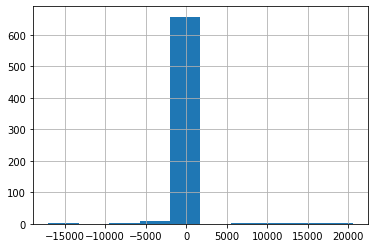

In [331]:
trans_before_loan.groupby('account_id')['balance'].min().hist()

<AxesSubplot:>

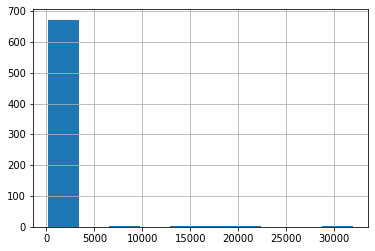

In [332]:
trans_before_loan.groupby(['account_id'])['balance'].head(1).hist()

All time balance
average balance

<AxesSubplot:>

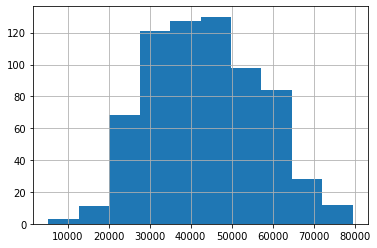

In [335]:
trans_before_loan.groupby(['account_id'])['balance'].mean().hist()

In [337]:
df['balance_mean'] = trans_before_loan.groupby(['account_id'])['balance'].mean().reset_index(drop=True)
df['balance_min'] = trans_before_loan.groupby(['account_id'])['balance'].min().reset_index(drop=True)
df['balance_max'] = trans_before_loan.groupby(['account_id'])['balance'].max().reset_index(drop=True)
# df['balance_median'] = trans_before_loan.groupby(['account_id'])['balance'].median().reset_index(drop=True)
# df['balance_var'] = trans_before_loan.groupby(['account_id'])['balance'].var().reset_index(drop=True)
df.head()

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,card_type_junior,num_inhabitants,urban_rate,avg_salary,num_enterpreneurs_per1000inhabitants,unemploy_rate,number_crimes,balance_mean,balance_min,balance_max
0,2,80952,24,3373,A,monthly,313,120.482428,4.124601,116.357827,...,0,1204953,1.000,12541,167,0.315,92392.0,32590.759259,1100,67530
1,19,30276,12,2523,B,monthly,388,335.966495,7.306701,328.659794,...,0,103347,0.670,9104,123,1.785,2326.5,25197.137500,715,58158
2,25,30276,12,2523,A,monthly,498,204.881526,8.206827,196.674699,...,0,228848,0.572,9893,96,4.360,5755.0,62991.408537,900,119653
3,37,318480,60,5308,D,monthly,422,74.492891,5.457346,69.035545,...,0,70646,0.584,8547,120,3.120,1552.5,39954.034483,-1011,104762
4,38,110736,48,2307,C,weekly,254,117.125984,4.385827,112.740157,...,0,51428,0.527,8402,120,3.540,1049.0,31383.581818,13841,55991


last month, last 3 months balance min

In [338]:
trans_before_loan['loan_date'] = pd.to_datetime(trans_before_loan['loan_date'])
trans_before_loan['last_month_before_loan'] = trans_before_loan['loan_date'] - pd.Timedelta(days=31)
trans_before_loan['last_3_months_before_loan'] = trans_before_loan['loan_date'] - pd.Timedelta(days=31*3)
trans_before_loan.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,last_month_before_loan,last_3_months_before_loan
0,2,1993-02-26,credit,credit_in_cash,1100,1100,NaN,1100.0,0.0,1994-01-05,313.0,1993-12-05,1993-10-04
1,2,1993-03-12,credit,collection_from_anotherbank,20236,21336,NaN,20236.0,0.0,1994-01-05,299.0,1993-12-05,1993-10-04
2,2,1993-03-28,credit,credit_in_cash,3700,25036,NaN,3700.0,0.0,1994-01-05,283.0,1993-12-05,1993-10-04
3,2,1993-03-31,credit,NaN,14,25050,interest_credited,14.0,0.0,1994-01-05,280.0,1993-12-05,1993-10-04
4,2,1993-04-12,credit,collection_from_anotherbank,20236,45286,NaN,20236.0,0.0,1994-01-05,268.0,1993-12-05,1993-10-04


In [339]:
last_month_before_loan = trans_before_loan[trans_before_loan['date'] >= trans_before_loan['last_month_before_loan']]
last_month_before_loan.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,last_month_before_loan,last_3_months_before_loan
45,2,1993-12-05,withdrawal,remittance_to_anotherbank,7266,24559,household,0.0,7266.0,1994-01-05,31.0,1993-12-05,1993-10-04
46,2,1993-12-08,withdrawal,withdrawal_in_cash,3500,21059,NaN,0.0,3500.0,1994-01-05,28.0,1993-12-05,1993-10-04
47,2,1993-12-10,withdrawal,withdrawal_in_cash,4200,16859,NaN,0.0,4200.0,1994-01-05,26.0,1993-12-05,1993-10-04
48,2,1993-12-12,credit,collection_from_anotherbank,30354,47213,NaN,30354.0,0.0,1994-01-05,24.0,1993-12-05,1993-10-04
49,2,1993-12-19,withdrawal,withdrawal_in_cash,3000,44213,NaN,0.0,3000.0,1994-01-05,17.0,1993-12-05,1993-10-04


In [340]:
df['balance_min_last_month'] = last_month_before_loan.groupby(by='account_id')['balance'].min().reset_index(drop=True)
df['balance_max_last_month'] = last_month_before_loan.groupby(by='account_id')['balance'].max().reset_index(drop=True)
df['balance_mean_last_month'] = last_month_before_loan.groupby(by='account_id')['balance'].mean().reset_index(drop=True)
# df['balance_median_last_month'] = last_month_before_loan.groupby(by='account_id')['balance'].median().reset_index(drop=True)
# df['balance_var_last_month'] = last_month_before_loan.groupby(by='account_id')['balance'].var().reset_index(drop=True)
df.head()

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,avg_salary,num_enterpreneurs_per1000inhabitants,unemploy_rate,number_crimes,balance_mean,balance_min,balance_max,balance_min_last_month,balance_max_last_month,balance_mean_last_month
0,2,80952,24,3373,A,monthly,313,120.482428,4.124601,116.357827,...,12541,167,0.315,92392.0,32590.759259,1100,67530,16859,47213,29792.555556
1,19,30276,12,2523,B,monthly,388,335.966495,7.306701,328.659794,...,9104,123,1.785,2326.5,25197.137500,715,58158,715,18915,14062.500000
2,25,30276,12,2523,A,monthly,498,204.881526,8.206827,196.674699,...,9893,96,4.360,5755.0,62991.408537,900,119653,31622,119653,64026.555556
3,37,318480,60,5308,D,monthly,422,74.492891,5.457346,69.035545,...,8547,120,3.120,1552.5,39954.034483,-1011,104762,16368,49186,33760.700000
4,38,110736,48,2307,C,weekly,254,117.125984,4.385827,112.740157,...,8402,120,3.540,1049.0,31383.581818,13841,55991,23807,37648,31890.750000


In [341]:
last_3months_before_loan = trans_before_loan[trans_before_loan['date'] >= trans_before_loan['last_3_months_before_loan']]
last_3months_before_loan.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,last_month_before_loan,last_3_months_before_loan
34,2,1993-10-05,withdrawal,remittance_to_anotherbank,7266,10508,household,0.0,7266.0,1994-01-05,92.0,1993-12-05,1993-10-04
35,2,1993-10-12,credit,collection_from_anotherbank,20236,30744,NaN,20236.0,0.0,1994-01-05,85.0,1993-12-05,1993-10-04
36,2,1993-10-24,withdrawal,withdrawal_in_cash,3000,27744,NaN,0.0,3000.0,1994-01-05,73.0,1993-12-05,1993-10-04
37,2,1993-10-31,withdrawal,withdrawal_in_cash,15,27830,payment_for_statement,0.0,15.0,1994-01-05,66.0,1993-12-05,1993-10-04
38,2,1993-10-31,credit,NaN,101,27845,interest_credited,101.0,0.0,1994-01-05,66.0,1993-12-05,1993-10-04


In [342]:
df['balance_min_last_3months'] = last_3months_before_loan.groupby(by='account_id')['balance'].min().reset_index(drop=True)
df['balance_max_last_3months'] = last_3months_before_loan.groupby(by='account_id')['balance'].max().reset_index(drop=True)
df['balance_mean_last_3months'] = last_3months_before_loan.groupby(by='account_id')['balance'].mean().reset_index(drop=True)
# df['balance_median_last_3months'] = last_3months_before_loan.groupby(by='account_id')['balance'].median().reset_index(drop=True)
# df['balance_var_last_3months'] = last_3months_before_loan.groupby(by='account_id')['balance'].var().reset_index(drop=True)
df.head()

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,number_crimes,balance_mean,balance_min,balance_max,balance_min_last_month,balance_max_last_month,balance_mean_last_month,balance_min_last_3months,balance_max_last_3months,balance_mean_last_3months
0,2,80952,24,3373,A,monthly,313,120.482428,4.124601,116.357827,...,92392.0,32590.759259,1100,67530,16859,47213,29792.555556,10508,47213,29326.650000
1,19,30276,12,2523,B,monthly,388,335.966495,7.306701,328.659794,...,2326.5,25197.137500,715,58158,715,18915,14062.500000,715,35162,15123.190476
2,25,30276,12,2523,A,monthly,498,204.881526,8.206827,196.674699,...,5755.0,62991.408537,900,119653,31622,119653,64026.555556,31622,119653,67839.300000
3,37,318480,60,5308,D,monthly,422,74.492891,5.457346,69.035545,...,1552.5,39954.034483,-1011,104762,16368,49186,33760.700000,-1011,49186,20563.071429
4,38,110736,48,2307,C,weekly,254,117.125984,4.385827,112.740157,...,1049.0,31383.581818,13841,55991,23807,37648,31890.750000,15671,37648,26212.692308


avg balance / loan payment
avg balance / loan amount

In [343]:
df['balance_mean_per_loan_payment'] = df['balance_mean'].div(df['loan_payments'], axis=0)
df['balance_mean_last_month_per_loan_payment'] = df['balance_mean_last_month'].div(df['loan_payments'], axis=0)
# df['balance_mean_last_3months_per_loan_payment'] = df['balance_mean_last_3months'].div(df['loan_payments'], axis=0)

df['balance_mean_per_loan_amount'] = df['balance_mean'].div(df['loan_amount'], axis=0)
df['balance_mean_last_month_per_loan_amount'] = df['balance_mean_last_month'].div(df['loan_amount'], axis=0)
# df['balance_mean_last_3months_per_loan_amount'] = df['balance_mean_last_3months'].div(df['loan_amount'], axis=0)

In [ ]:
# df[['balance_mean', 'balance_mean_last_month', 'balance_mean_last_3months']]

average balance, average amount growth from first month, last month ,and last 3 months. 

In [344]:
last_3months_ago = trans_before_loan[(trans_before_loan['date'] > trans_before_loan['last_3_months_before_loan']) & (trans_before_loan['date'] <= trans_before_loan['last_3_months_before_loan'] + pd.Timedelta(days=31))]
last_3months_ago.head()

,account_id,date,type,operation,amount,balance,k_symbol,amount_in,amount_out,loan_date,day_after_loan,last_month_before_loan,last_3_months_before_loan
34,2,1993-10-05,withdrawal,remittance_to_anotherbank,7266,10508,household,0.0,7266.0,1994-01-05,92.0,1993-12-05,1993-10-04
35,2,1993-10-12,credit,collection_from_anotherbank,20236,30744,NaN,20236.0,0.0,1994-01-05,85.0,1993-12-05,1993-10-04
36,2,1993-10-24,withdrawal,withdrawal_in_cash,3000,27744,NaN,0.0,3000.0,1994-01-05,73.0,1993-12-05,1993-10-04
37,2,1993-10-31,withdrawal,withdrawal_in_cash,15,27830,payment_for_statement,0.0,15.0,1994-01-05,66.0,1993-12-05,1993-10-04
38,2,1993-10-31,credit,NaN,101,27845,interest_credited,101.0,0.0,1994-01-05,66.0,1993-12-05,1993-10-04


In [345]:
df['growth_balance'] = (df['balance_mean_last_month'] - last_3months_ago.groupby('account_id')['balance'].mean().reset_index(drop=True)) / (30*3)

<AxesSubplot:>

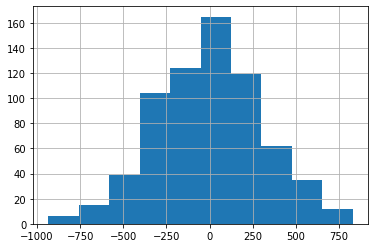

In [346]:
df['growth_balance'].hist()

In [347]:
df.columns

Index(['account_id', 'loan_amount', 'loan_duration', 'loan_payments',
       'loan_status', 'acc_frequency', 'day_before_loan',
       'sum_monthly_payment_amount', 'sum_monthly_payment_amount_in',
       'sum_monthly_payment_amount_out', 'sum_monthly_payment_out_household',
       'sum_monthly_payment_out_insurrance',
       'sum_monthly_payment_in_interest_credited',
       'sum_monthly_payment_out_payment_for_statement',
       'sum_monthly_payment_out_sanction_interest_neg_bal',
       'count_out_sanction_interest_neg_bal', 'count_monthly_payment_trans',
       'current_monthly_payment_amount_out',
       'current_monthly_payment_out_household',
       'current_monthly_payment_out_insurrance',
       'current_monthly_payment_out_payment_for_statement',
       'current_monthly_payment_in_interest_credited', 'sum_other_amount',
       'sum_other_amount_in', 'sum_other_amount_out', 'count_other_trans',
       'balance_latest', 'client_gender', 'client_age', 'all_client_mean_age',
    

* amount growth
* sum amount out per month
* sum amount out per month / loan payments

In [348]:
last_month_before_loan = trans_before_loan[trans_before_loan['date'] >= trans_before_loan['last_month_before_loan']]

last_3months_before_loan = trans_before_loan[trans_before_loan['date'] >= trans_before_loan['last_3_months_before_loan']]

In [349]:
df[['amount_last_month', 'amount_last_month_in', 'amount_last_month_out']] = last_month_before_loan.groupby('account_id')[['amount', 'amount_in', 'amount_out']].sum().reset_index(drop=True)
df[['amount_last_month_per_loan_payments', 'amount_last_mount_in_per_loan_payments', 'amount_last_mount_out_per_loan_payments']] = df[['amount_last_month', 'amount_last_month_in', 'amount_last_month_out']].div(df['loan_payments'], axis=0)
df[['amount_last_month_per_loan_amount', 'amount_last_mount_in_per_loan_amount', 'amount_last_mount_out_per_loan_amount']] = df[['amount_last_month', 'amount_last_month_in', 'amount_last_month_out']].div(df['loan_amount'], axis=0)

df[['amount_last_3months_avg', 'amount_last_3months_in_avg', 'amount_last_3months_out_avg']] = last_3months_before_loan.groupby('account_id')[['amount', 'amount_in', 'amount_out']].sum().reset_index(drop=True) / 3
df[['amount_last_3months_per_loan_payments', 'amount_last_3months_in_per_loan_payments', 'amount_last_3months_out_per_loan_payments']] = df[['amount_last_3months_avg', 'amount_last_3months_in_avg', 'amount_last_3months_out_avg']].div(df['loan_payments'], axis=0)
df[['amount_last_3months_per_loan_amount', 'amount_last_3months_in_per_loan_amount', 'amount_last_3months_out_per_loan_amount']] = df[['amount_last_3months_avg', 'amount_last_3months_in_avg', 'amount_last_3months_out_avg']].div(df['loan_amount'], axis=0)
df

,account_id,loan_amount,loan_duration,loan_payments,loan_status,acc_frequency,day_before_loan,sum_monthly_payment_amount,sum_monthly_payment_amount_in,sum_monthly_payment_amount_out,...,amount_last_mount_out_per_loan_amount,amount_last_3months_avg,amount_last_3months_in_avg,amount_last_3months_out_avg,amount_last_3months_per_loan_payments,amount_last_3months_in_per_loan_payments,amount_last_3months_out_per_loan_payments,amount_last_3months_per_loan_amount,amount_last_3months_in_per_loan_amount,amount_last_3months_out_per_loan_amount
0,2,80952,24,3373,A,monthly,313,120.482428,4.124601,116.357827,...,0.425894,44114.333333,23734.666667,20379.666667,13.078664,7.036664,6.042000,0.544944,0.293194,0.251750
1,19,30276,12,2523,B,monthly,388,335.966495,7.306701,328.659794,...,0.601632,36373.333333,17858.333333,18515.000000,14.416700,7.078214,7.338486,1.201392,0.589851,0.611540
2,25,30276,12,2523,A,monthly,498,204.881526,8.206827,196.674699,...,3.150482,115321.666667,53753.000000,61568.666667,45.708152,21.305192,24.402959,3.809013,1.775433,2.033580
3,37,318480,60,5308,D,monthly,422,74.492891,5.457346,69.035545,...,0.103344,60867.000000,30319.333333,30547.666667,11.467031,5.712007,5.755024,0.191117,0.095200,0.095917
4,38,110736,48,2307,C,weekly,254,117.125984,4.385827,112.740157,...,0.089312,29212.333333,16590.333333,12622.000000,12.662477,7.191302,5.471175,0.263802,0.149819,0.113983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,39168,24,1632,C,monthly,347,70.360231,6.244957,64.115274,...,0.656352,38777.333333,20569.333333,18208.000000,23.760621,12.603758,11.156863,0.990026,0.525157,0.464869
678,11328,280440,60,4674,C,monthly,620,5.864516,5.501613,0.362903,...,0.076412,42196.000000,20453.333333,21742.666667,9.027813,4.375981,4.651833,0.150464,0.072933,0.077531
679,11349,419880,60,6998,C,weekly,156,74.634615,4.852564,69.782051,...,0.200500,96056.000000,42327.333333,53728.666667,13.726207,6.048490,7.677717,0.228770,0.100808,0.127962
680,11359,54024,12,4502,A,monthly,675,119.515556,5.328889,114.186667,...,0.390327,65997.333333,31656.000000,34341.333333,14.659559,7.031542,7.628017,1.221630,0.585962,0.635668


In [ ]:
# last_3months_ago = trans_before_loan[(trans_before_loan['date'] > trans_before_loan['last_3_months_before_loan']) & (trans_before_loan['date'] <= trans_before_loan['last_3_months_before_loan'] + pd.Timedelta(days=31))]
# last_3months_ago.head()

In [ ]:
# df['growth_amount_in'] = (df['amount_last_month_in'] - last_3months_ago.groupby('account_id')['amount_in'].sum().reset_index(drop=True)) / (30*3)
# df['growth_amount_out'] = (df['amount_last_month_out'] - last_3months_ago.groupby('account_id')['amount_out'].sum().reset_index(drop=True)) / (30*3)

In [ ]:
# df['growth_amount_in'].hist()

In [ ]:
# df['growth_amount_out'].hist()

In [350]:
df.shape

(682, 72)

In [351]:
df.isna().any()

account_id                                   False
loan_amount                                  False
loan_duration                                False
loan_payments                                False
loan_status                                  False
                                             ...  
amount_last_3months_in_per_loan_payments     False
amount_last_3months_out_per_loan_payments    False
amount_last_3months_per_loan_amount          False
amount_last_3months_in_per_loan_amount       False
amount_last_3months_out_per_loan_amount      False
Length: 72, dtype: bool

In [ ]:
df.columns

In [354]:
df.to_csv('transformed_data/final_transformed_data.csv', index=False)

In [355]:
dff = df.copy()
dff.drop(['sum_monthly_payment_amount', 'sum_monthly_payment_amount_in', 'sum_monthly_payment_amount_out',
         'day_before_loan', 'current_monthly_payment_out_payment_for_statement', 'sum_other_amount',
         'sum_other_amount_in', 'sum_other_amount_out', 'client_age', 'all_client_mean_age', 
         'num_inhabitants', 'urban_rate', 'num_enterpreneurs_per1000inhabitants', 'unemploy_rate', 'balance_max',
         'balance_mean_per_loan_payment', 'balance_mean_per_loan_amount', 'amount_last_month', 'amount_last_month_in',
         'amount_last_month_per_loan_payments', 'amount_last_month_per_loan_amount', 'amount_last_3months_avg',
         'amount_last_3months_in_avg', 'amount_last_3months_out_avg', 'amount_last_3months_per_loan_payments', 
         'amount_last_3months_per_loan_amount', 'balance_min_last_3months', 'balance_max_last_3months', 'balance_mean_last_3months',
         'amount_last_3months_per_loan_payments'], axis=1, inplace=True)

In [356]:
dff.shape

(682, 43)

In [357]:
dff.to_csv('transformed_data/final_dropped_transformed_data.csv', index=False)

In [358]:
dff.isna().any().any()

True

In [ ]:
import pandas as pd

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

report = pd.DataFrame({'probs':probs, 'y_true':y_true})
report['y_pred'] = to_labels(report['probs'], 0.85)
report['case_TP'] = report['y_true'].astype(int) & report['y_pred'].astype(int) 
report['case_FN'] = ((report['y_true'].astype(int) == 1) & (report['y_pred'].astype(int) == 0)).astype(int)
report['case_FP'] = ((report['y_true'].astype(int) == 0) & (report['y_pred'].astype(int) == 1)).astype(int)
report['case_TN'] = ( report['y_true'].astype(int) | report['y_pred'].astype(int) == 0).astype(int)
print(report)

In [ ]:
import numpy as np

In [ ]:
report = pd.read_csv('report_xgb.csv')
report['y_pred'] = np.nan
report['case_TP'] = np.nan
report['case_FN'] = np.nan
report['case_FP'] = np.nan
report['case_TN'] = np.nan
report['threshold'] = np.nan
report

In [ ]:
def profit_thresholding(df, th_, profit, interest_rate):
    df['y_pred'] = to_labels(df['probs'], th_)
    # TN
    df.loc[(df['y_true']==0) & (df['y_pred']==0), ['profit']] = profit
    df.loc[(df['y_true']==0) & (df['y_pred']==0), ['conf']] = 'tn'

    # TP 
    df.loc[(df['y_true']==1) & (df['y_pred']==1), ['profit']] = 0
    df.loc[(df['y_true']==1) & (df['y_pred']==1), ['conf']] = 'tp'

    # FN
    df.loc[(df['y_true']==0) & (df['y_pred']==1), ['profit']] = 0
    df.loc[(df['y_true']==0) & (df['y_pred']==1), ['conf']] = 'fn'
    
    # FP
    df.loc[(df['y_true']==1) & (df['y_pred']==0), ['profit']] = profit
    df.loc[(df['y_true']==1) & (df['y_pred']==0), ['conf']] = 'fp'
            
    df['threshold'] = th_
    df['interest_rate'] = interest_rate
    
    return df

In [ ]:
def cal_revenue(total_amount, loan_duration_month, paid_month, interest_rate_peryear):
    '''
    Interest (Compound) = P(1+i)^t - P
    P = all / (1+i)^t
    '''
    principle = total_amount / (1+interest_rate_peryear)**(loan_duration_month//12)
    expected_revenue = total_amount - principle
    revenue = paid_month * expected_revenue / loan_duration_month
    return revenue

def cal_cost(loan_payment, loan_duration_month, paid_month):
    not_paid_month = loan_duration_month - paid_month
    cost = not_paid_month * loan_payment
    return cost

In [ ]:
loan_df = pd.read_csv('data/loan.csv')
loan_df.head()

In [ ]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [ ]:
url = 'https://raw.githubusercontent.com/sorayutmild/loan-default-prediction/main/after_trans_payment_for_loan.csv?raw=true'
after_trans_for_loan = pd.read_csv(url)

interest_rate_peryear = [0.01, 0.03, 0.05, 0.1, 0.2]
profits = []
report = pd.read_csv('report_xgb.csv')
reports = []

for i in interest_rate_peryear:
    revenue = cal_revenue(total_amount=loan_df['amount'], 
                    loan_duration_month=loan_df['duration'], 
                    paid_month=after_trans_for_loan['count_loan_trans'], 
                    interest_rate_peryear=i)

    cost = cal_cost(loan_payment=loan_df['payments'], 
                    loan_duration_month=loan_df['duration'],
                    paid_month=after_trans_for_loan['count_loan_trans'])

    profit = revenue - cost



    
    
    for th in np.arange(0, 1.1, 0.1):
        th_ = th.round(decimals=1)
        r = profit_thresholding(report, th_, profit, i).reset_index(drop=True)
        reports.append(r)
          
    profits.append(profit.sum())

reports = pd.concat(reports)
reports

In [ ]:
reports[(reports['threshold']==0.5) & (reports['interest_rate']==0.05)][['profit']].sum()

In [ ]:
reports.to_csv('report_xgb_threshold_prfit.csv', index=False)

In [ ]:
ori_profit = pd.DataFrame({'interest rate per year': interest_rate_peryear, 
              'Old profit':profits})

ori_profit.to_csv('ori_profit.csv', index=False)

In [ ]:
ori_profit